In [1]:
%pip install scikit-learn
import torch
import torch.nn as nn
import numpy as np
from ase.build import molecule
from ase.calculators.emt import EMT

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.9 MB 3.3 MB/s eta 0:00:03
   ------------------ --------------------- 4.2/8.9 MB 8.4 MB/s eta 0:00:01
   -------------------------------------- - 8.7/8.9 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 12.0 MB/s  0:00:01

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-lear

In [2]:
# Build water molecule
h2o = molecule('H2O')

# Assign EMT calculator
h2o.calc = EMT()

In [12]:
# Extract positions (3 atoms, 3D each → 9 values)
pos = h2o.get_positions().flatten()  # Flatten to 1D array

# Create small random perturbations
X_data = []
Y_data = []

for i in range(100):  # 50 data points
    perturb = pos + np.random.normal(0, 0.1, size=pos.shape)  # ±0.05 Å noise
    h2o.set_positions(perturb.reshape(-1,3))  # Reshape to 3x3
    energy = h2o.get_potential_energy()      # EMT energy
    X_data.append(perturb)
    Y_data.append(energy)
    
X_data = torch.tensor(X_data, dtype=torch.float32)
Y_data = torch.tensor(Y_data, dtype=torch.float32).view(-1,1)

In [13]:
# Tiny NN for 9 inputs → 1 output
model = nn.Sequential(
    nn.Linear(9, 40),
    nn.ReLU(),
    nn.Linear(40, 1)
)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
for epoch in range(100000):
    optimizer.zero_grad()
    y_pred = model(X_data)
    loss = criterion(y_pred, Y_data)
    loss.backward()
    optimizer.step()
    
print("Training complete")

from sklearn.metrics import r2_score
r2= r2_score(Y_data.numpy(),model(X_data).detach().numpy())
print(f"R² score: {r2:.4f}")

Training complete
R² score: 0.9997


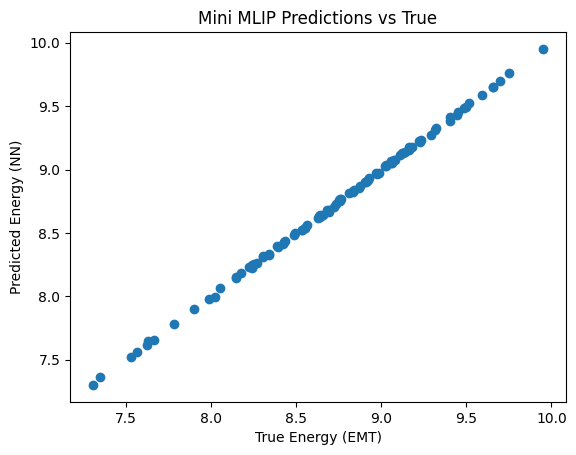

In [17]:
pred = model(X_data).detach().numpy()  # Detach from PyTorch graph
true = Y_data.numpy()

import matplotlib.pyplot as plt

plt.scatter(true, pred)
plt.xlabel("True Energy (EMT)")
plt.ylabel("Predicted Energy (NN)")
plt.title("Mini MLIP Predictions vs True")
plt.show()